In [3]:
import numpy as np
import seaborn as sns
import scipy.io as sio
import pandas as pd

from scipy.signal import welch
from scipy.fftpack import rfft
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d


plt.rcParams['figure.figsize'] = (10, 6)

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Tomamos un epoch del electrodo 8 de una persona y calculamos welch

In [6]:
s1 = sio.loadmat('dataset/S01.mat')
array  = s1['data'] # una matriz tridimensional: trials/epochs x electrodos x muestras en Epoch

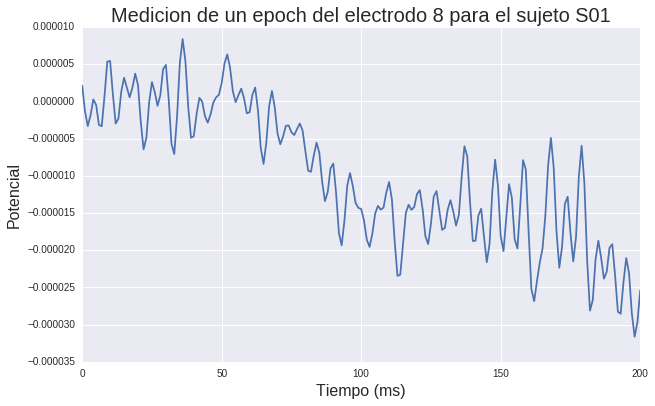

In [23]:
muestras8= array[:,8][0]
muestras8
plt.plot(muestras8)
plt.xlabel("Tiempo (ms)", fontsize=16)
plt.ylabel("Potencial", fontsize=16)
plt.title("Medicion de un epoch del electrodo 8 para el sujeto S01", fontsize=20)
plt.show()

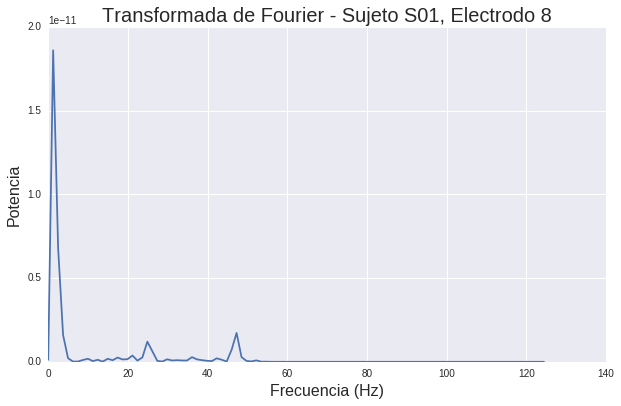

In [24]:
ff= welch(muestras8, fs=250, nperseg=201)
plt.plot(ff[0],ff[1])
plt.xlabel("Frecuencia (Hz)", fontsize=16)
plt.ylabel("Potencia", fontsize=16)
plt.title("Transformada de Fourier - Sujeto S01, Electrodo 8", fontsize=20)
plt.show()


### Comparo los graficos de las frecuencias con picos con la medicion del electrodo

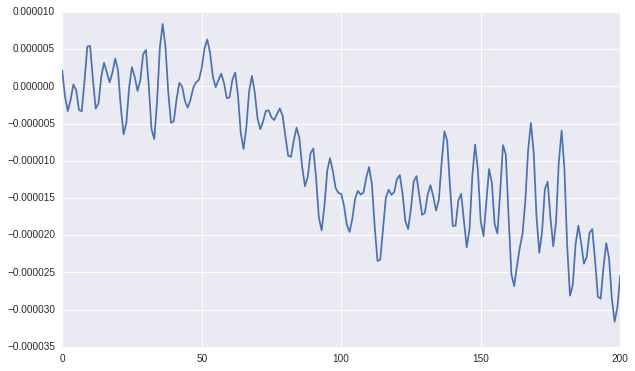

In [25]:
#Esto yo lo volaria, no nos salio hacerlo

omega = ff[0][31]
plt.plot(muestras8)
# plt.plot([np.sin(x*ff[0][1]) for x in range(0,201)])
# plt.plot([0.000010*np.sin(x/omega) for x in range(0,201)])
plt.show()

### Intentamos promediando los epochs para un electrodo

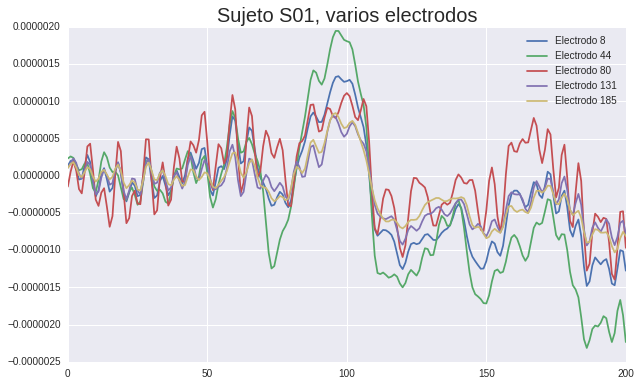

In [27]:
for i in [8,44,80, 131,185]:
    muestras= array[:,i].mean(axis=0)
    plt.plot(muestras, label="Electrodo {}".format(i))
plt.title("Sujeto S01, varios electrodos", fontsize=20)
plt.legend(loc='best')
plt.show()

In [28]:
electrodos = [8,44,80, 131,185]
muestras = np.array([0]*201)
for i in electrodos:
    muestras = np.add(muestras,array[:,i])
muestras = muestras/len(electrodos)
# muestras= array[:,8]
fouriers = []
matriz = []
for i in range(len(muestras)):
     freqs, pot = welch(muestras[i], fs=250, nperseg=201)
     matriz.append(pot)
npmatriz = np.array(matriz)

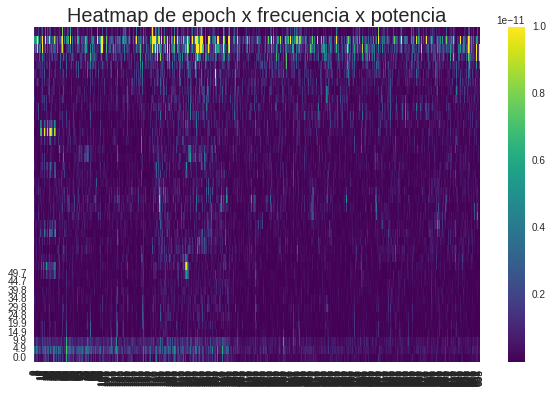

In [30]:
ax = sns.heatmap(npmatriz.transpose()[0:40], cmap="viridis", vmax=1e-11)
freqs = [freq for freq in freqs if freq<50]
freqs = [int(freq*10)/10.0 for freq in freqs]
freqs = [freqs[i] for i in range(len(freqs)) if i%2==0]
ax.set_yticklabels(freqs, rotation='horizontal')
plt.title("Heatmap de epoch x frecuencia x potencia", fontsize=20)
plt.show()

In [4]:
filenamesP = ['dataset/P0'+str(i)+'.mat' for i in range(1,10)]+['dataset/P10.mat']
filenamesS = ['dataset/S0'+str(i)+'.mat' for i in range(1,10)]+['dataset/S10.mat']
bandas = ['delta', 'epsilon', 'alfa', 'beta', 'gamma']

In [7]:
def FrecuenciasPorTipo(archivos):
    freqPotXPersona = []
    for filename in archivos:
        array = sio.loadmat(filename)['data']
        ffs = []
        for i in range(256):
            muestras= array[:,i][0]
            ff= welch(muestras, fs=250, nperseg=201)
            ffs.append(ff[1])
        frecuencia = ff[0]
        arrayffs = np.array(ffs)
        freqPotXPersona.append((frecuencia,arrayffs.mean(axis=0)))
    for index, freqPot in enumerate(freqPotXPersona):
        plt.plot(freqPot[0],freqPot[1], label='S'+str(index+1))
    plt.legend(loc='best')
    plt.xlim(0,50)
    plt.show()
    
    return freqPotXPersona

def PromedioBandas(freqPotXPersona):
    proms = []#
    for j in range(len(freqPotXPersona)):
        proms.append([])
        freqPot = freqPotXPersona[j]
        buckets = [0,0,0,0,0]
        count = [0,0,0,0,0]
    
        for i in range(len(freqPot[1])):
            if freqPot[0][i] < 4:
                buckets[0] += freqPot[1][i]
                count[0] +=1
            elif freqPot[0][i] < 8:
                buckets[1] += freqPot[1][i]
                count[1] +=1
            elif freqPot[0][i] < 13:
                buckets[2] += freqPot[1][i]
                count[2] +=1
            elif freqPot[0][i] < 30:
                buckets[3] += freqPot[1][i]
                count[3] +=1
            else:
                buckets[4] += freqPot[1][i]
                count[4] +=1

        
        for i in range(len(buckets)):
            proms[j].append(buckets[i]/count[i])
    
    return proms
    

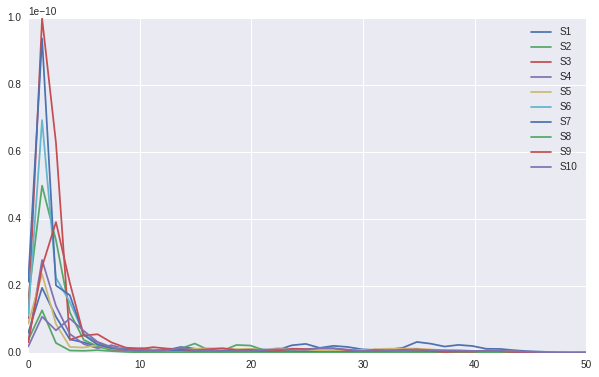

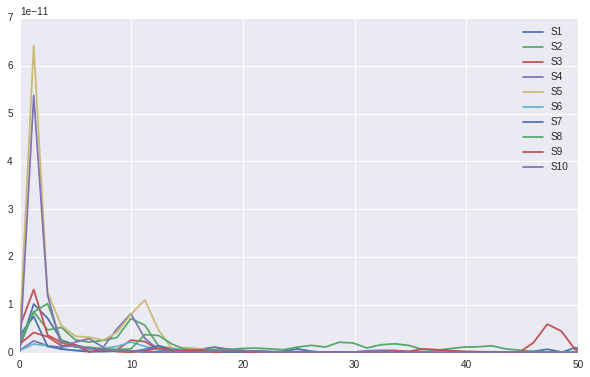

In [8]:
frecuenciasP = FrecuenciasPorTipo(filenamesP) #FrecuenciasPorTipo plotea
frecuenciasS = FrecuenciasPorTipo(filenamesS)

bandasP = PromedioBandas(frecuenciasP)
bandasS = PromedioBandas(frecuenciasS)

In [19]:
tablaP = pd.DataFrame(bandasP, columns=bandas, index=['P'+str(i) for i in range(1,11)])
tablaS = pd.DataFrame(bandasS, columns=bandas, index=['S'+str(i) for i in range(1,11)])
tablaP['Tipo'] = 'P'
tablaS['Tipo'] = 'S'

todos = pd.concat([tablaP, tablaS])
todos[['alfa', 'Tipo']]

,alfa,Tipo
P1,8.541332e-13,P
P2,9.441444e-13,P
P3,4.677259e-13,P
P4,6.317732e-13,P
P5,9.139240e-13,P
P6,9.841203e-13,P
P7,8.259268e-13,P
P8,1.601030e-13,P
P9,1.411789e-12,P
P10,7.665726e-13,P


### Distribución de las distintas bandas de frecuencia para los dos grupos de sujetos

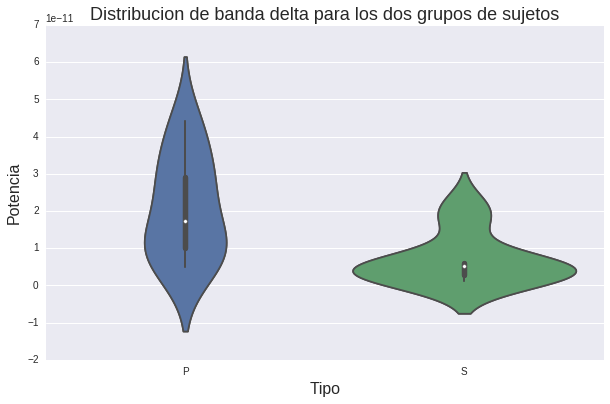

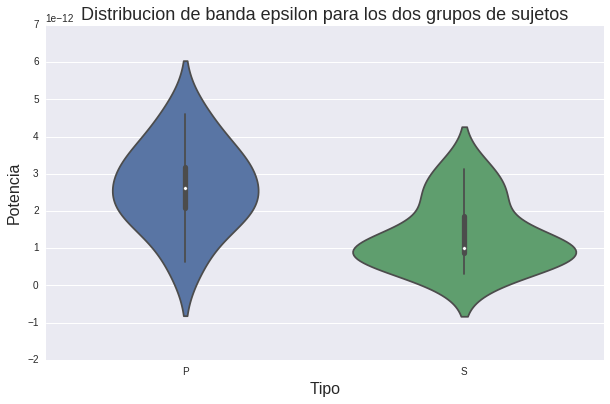

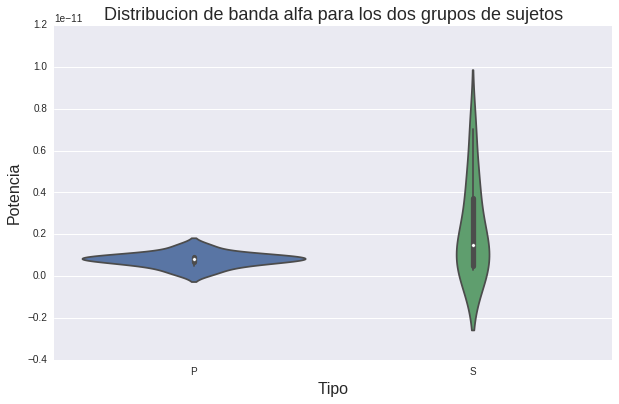

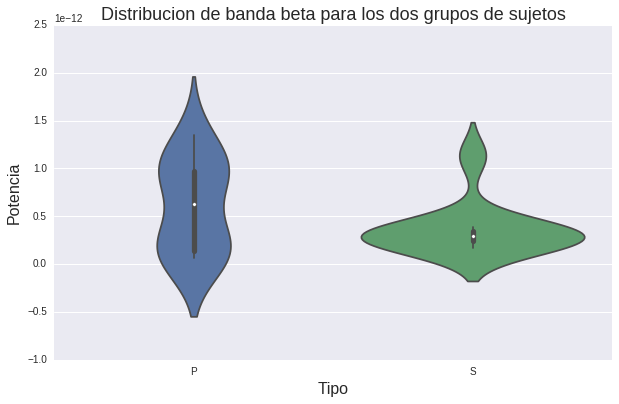

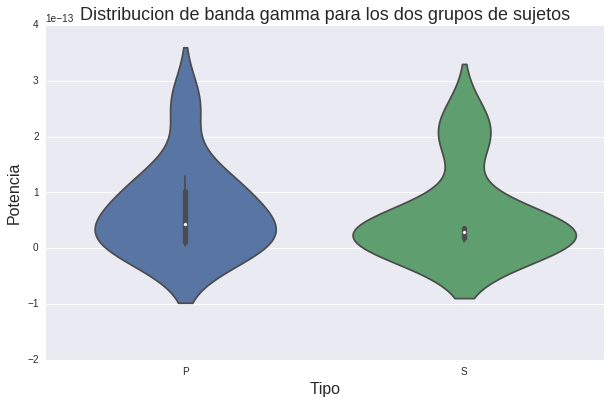

In [13]:
for banda in bandas:
    sns.violinplot(y=todos[banda], x=todos['Tipo'])
    plt.xlabel("Tipo", fontsize=16)
    plt.ylabel("Potencia", fontsize=16)
    plt.title("Distribucion de banda {} para los dos grupos de sujetos".format(banda), fontsize=18)
    plt.show()

##### Normalizamos los valores 

Para cada banda de frecuencia calculamos los valores normalizados como:
    
    norm(x_i_banda) = (x_i_banda - min(banda)) / (max(banda) - min(banda))

Duda: ¿Cómo los normalizamos?¿Respecto a la media o al intervalo [0,1]? Lo segundo deja los gráficos iguales.

#### Creo que esto está mal, hay que normalizar los datos de entrada ni bien los levantamos creo

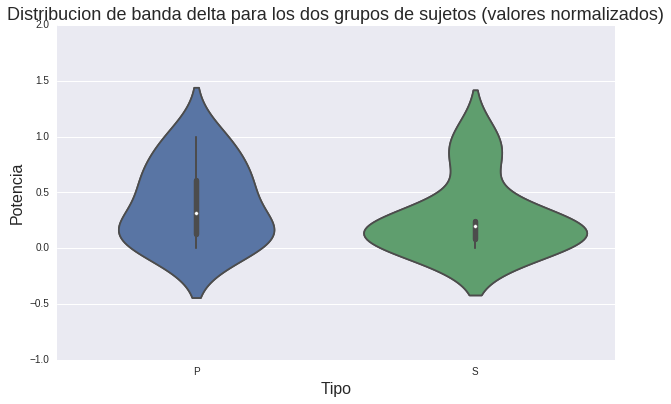

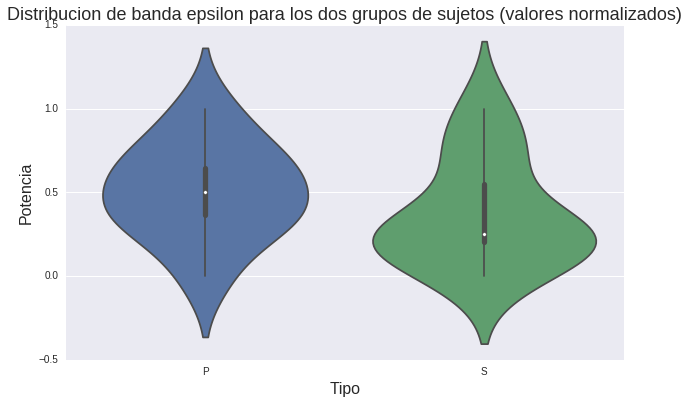

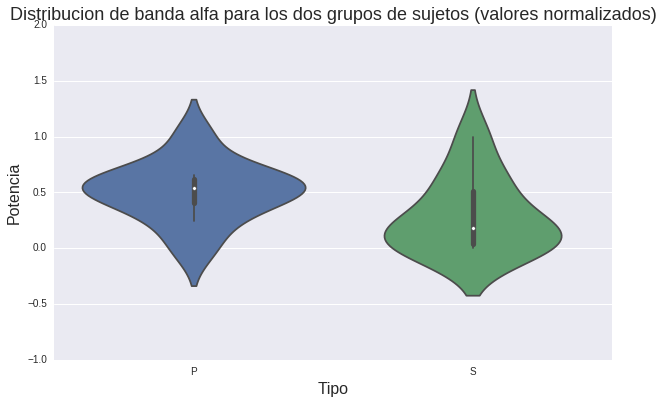

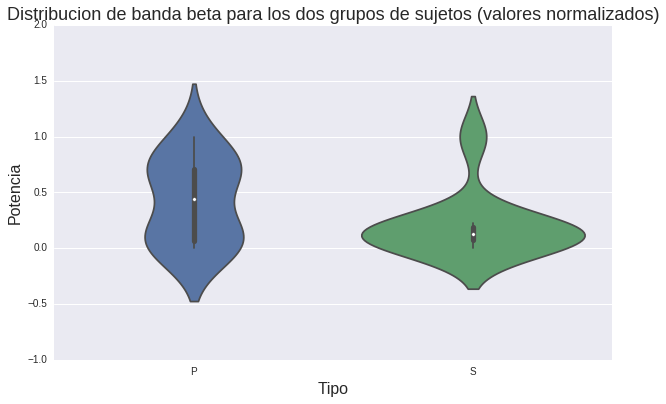

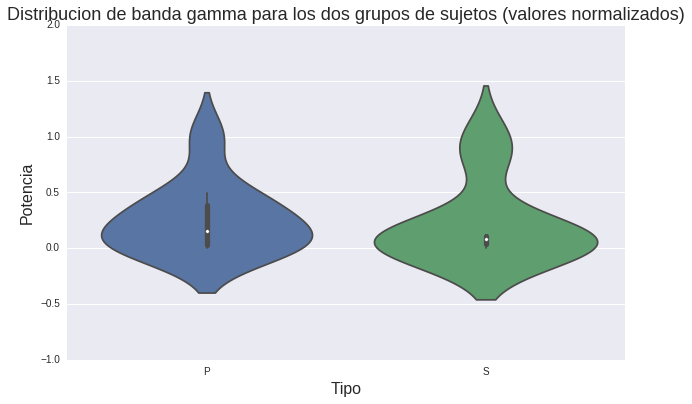

In [87]:
def NormalizarDataFrame(df):
    #Si normalizamos respecto a la medio cambiar el primer min por mean
    df_norm = (df[bandas] - df[bandas].min()) / (df[bandas].max() - df[bandas].min())
    df_norm['Tipo'] = df['Tipo']
    return df_norm

todos_norm = pd.concat([NormalizarDataFrame(tablaP), NormalizarDataFrame(tablaS)])

for banda in bandas:
    sns.violinplot(y=todos_norm[banda], x=todos_norm['Tipo'])
    plt.xlabel("Tipo", fontsize=16)
    plt.ylabel("Potencia", fontsize=16)
    plt.title("Distribucion de banda {} para los dos grupos de sujetos (valores normalizados)".format(banda), fontsize=18)
    plt.show()

In [83]:


def FrecuenciasPorTipoNormalizado(archivos):
    #Habria que cambiarlo para que vaya normalizando muestras
    freqPotXPersona = []
    for filename in archivos:
        array = sio.loadmat(filename)['data']
        ffs = []
        for i in range(256):
            muestras= array[:,i][0]
            ff= welch(muestras, fs=250, nperseg=201)
            ffs.append(ff[1])
        frecuencia = ff[0]
        arrayffs = np.array(ffs)
        freqPotXPersona.append((frecuencia,arrayffs.mean(axis=0)))
    for index, freqPot in enumerate(freqPotXPersona):
        plt.plot(freqPot[0],freqPot[1], label='S'+str(index+1))
    plt.legend(loc='best')
    plt.xlim(0,50)
    plt.show()
    
    return freqPotXPersona